# Amazon Reviews NLP + Sentiment Analysis
**Author:** Miguel Vásquez  
**Date:** September 2025  

---

## 1. Introduction

Online reviews have become a critical source of feedback for both consumers and businesses. Understanding the sentiment expressed in these reviews can provide insights into customer satisfaction, product quality, and market trends.  

In this project, we focus on **sentiment analysis** of Amazon product reviews. The dataset contains reviews spanning **18 years** and includes information such as user and product IDs, ratings, and plaintext review content. By leveraging Natural Language Processing (NLP) techniques, we aim to classify reviews into **positive** or **negative** sentiments and compare the performance of various machine learning and deep learning models, including Logistic Regression, SVM, and DistilBERT.

The goal of this analysis is twofold:
1. Demonstrate the ability to process and analyze large-scale textual data.
2. Build predictive models that can accurately classify review sentiment, providing a benchmark for future improvements.

For more details on the dataset, see:  
**J. McAuley and J. Leskovec. Hidden factors and hidden topics: understanding rating dimensions with review text. RecSys, 2013.**

---

## 2. Dataset
### 2.1 Load Data


In [1]:
import kagglehub
import os
import tarfile
import pandas as pd
from IPython.display import display, Markdown

# Download and extract the Amazon Reviews dataset from Kaggle
dataset_path = kagglehub.dataset_download("kritanjalijain/amazon-reviews")
display(Markdown(f"Dataset downloaded to: {dataset_path}"))

# Path to the .tgz file
tgz_path = os.path.join(dataset_path, "amazon_review_polarity_csv.tgz")

# Extract the .tgz
extract_path = os.path.join(dataset_path, "extracted")
if not os.path.exists(extract_path):
    with tarfile.open(tgz_path, "r:gz") as tar:
        tar.extractall(path=extract_path)
        display(Markdown(f"Files extracted to: {extract_path}"))

# Confirm what is inside
display(Markdown(f"Extracted contents: {os.listdir(extract_path)}"))

# Path to the already extracted train.csv
train_path = os.path.join(extract_path, "amazon_review_polarity_csv", "train.csv")

# Load in chunks
chunks = pd.read_csv(
    train_path,
    sep=",",
    engine="python",
    encoding="utf-8",
    on_bad_lines="skip",
    chunksize=500000
)

df = pd.concat(chunks)
display(Markdown(f"Shape: {df.shape}"))
display(df.head())


Dataset downloaded to: C:\Users\Miguel\.cache\kagglehub\datasets\kritanjalijain\amazon-reviews\versions\2

Extracted contents: ['amazon_review_polarity_csv']

Shape: (3599999, 3)

,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...


### 2.2 Subset dataset
We are going to take a more manageable subset (150k) from the total data (36M) to process.

In [2]:
subset = df.sample(150000, random_state=42)
subset.to_csv("amazon_reviews_subset.csv", index=False)
display(subset.shape)

(150000, 3)

## 3. EDA
### 3.1 Parsing data

In [3]:
# Add labels
df = pd.read_csv("amazon_reviews_subset.csv", header=None, names=["label", "title", "content"])
display(Markdown(f"Shape: {df.shape}"))
display(df.head(3))
display(df["label"].value_counts())

# Positive = 2, Negative = 1
label_map = {1: "negative", 2: "positive"}
df["sentiment"] = df["label"].map(label_map)

display(Markdown("Sentiment Count:"))
display(df["sentiment"].value_counts())

# Clean version
df.to_csv("amazon_reviews_clean.csv", index=False)
display(Markdown("✅ Save amazon_reviews_clean.csv"))

Shape: (150001, 3)

,label,title,content
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,Very disappointed,My son got this toy for his birthday. The kids...
2,1,Doesn't help with cats or dogs!,A person I work with highly recommended it. He...


label
1    75154
2    74847
Name: count, dtype: int64

Sentiment Count:

sentiment
negative    75154
positive    74847
Name: count, dtype: int64

✅ Save amazon_reviews_clean.csv

### 3.2 Class distribution

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Miguel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


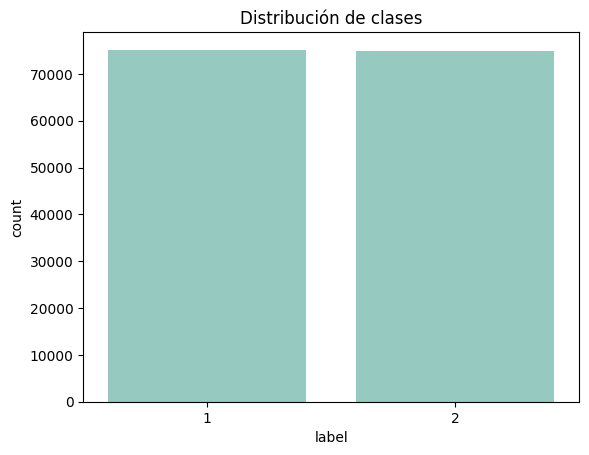

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re

sns.set_palette("Set3")

# English stop words
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

## Class distribution
sns.countplot(x="label", data=df)
plt.title("Distribución de clases")
plt.show()

### 3.3 Distribution of lengths

In [5]:
# Review length
df["review_length"] = df["content"].apply(lambda x: len(str(x).split()))
display(df["review_length"].describe())

count    150001.000000
mean         74.059026
std          42.318037
min           1.000000
25%          39.000000
50%          65.000000
75%         103.000000
max         213.000000
Name: review_length, dtype: float64

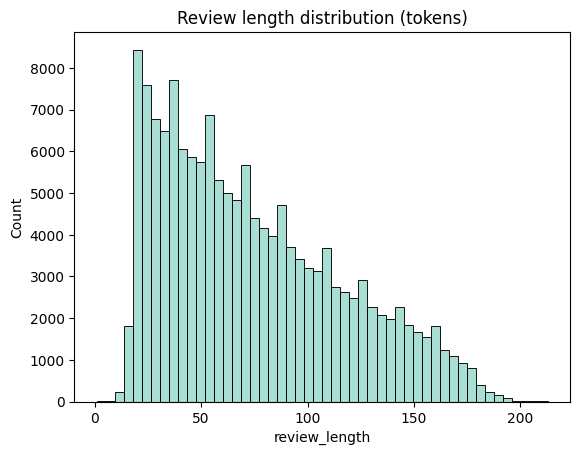

In [6]:
sns.histplot(df["review_length"], bins=50, kde=False)
plt.title("Review length distribution (tokens)")
plt.show()

### 3.4 Most common words

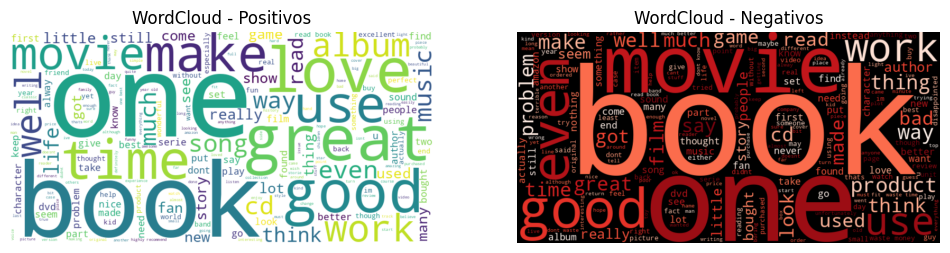

In [7]:
# Word Cloud per class
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return " ".join([w for w in text.split() if w not in stop_words])

text_pos = " ".join(df[df["label"]==2]["content"].apply(clean_text))
text_neg = " ".join(df[df["label"]==1]["content"].apply(clean_text))

wc_pos = WordCloud(width=800, height=400, background_color="white").generate(text_pos)
wc_neg = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(text_neg)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Positivos")

plt.subplot(1,2,2)
plt.imshow(wc_neg, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Negativos")
plt.show()

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to get top n-grams
def get_top_ngrams(corpus, n=1, top_k=20):
    vec = CountVectorizer(ngram_range=(n,n), stop_words="english").fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return pd.DataFrame(words_freq[:top_k], columns=["ngram", "freq"])

# Top unigrams per class
display(Markdown("Top unigrams - Positives"))
display(get_top_ngrams(df[df["label"]==2]["content"], n=1))

display(Markdown("Top unigrams - Negatives"))
display(get_top_ngrams(df[df["label"]==1]["content"], n=1))

# Top bigrams per class
display(Markdown("Top bigrams - Positives"))
display(get_top_ngrams(df[df["label"]==2]["content"], n=2))

display(Markdown("Top bigrams - Negatives"))
display(get_top_ngrams(df[df["label"]==1]["content"], n=2))

Top unigrams - Positives

,ngram,freq
0,book,37782
1,great,24952
2,good,19672
3,like,19485
4,just,15956
5,read,14816
6,love,12574
7,time,12308
8,really,11644
9,movie,9936


Top unigrams - Negatives

,ngram,freq
0,book,36853
1,like,21815
2,just,21796
3,good,15450
4,time,14151
5,don,13768
6,movie,12315
7,read,11628
8,really,10907
9,product,10644


Top bigrams - Positives

,ngram,freq
0,read book,2234
1,highly recommend,2012
2,year old,1666
3,years ago,1168
4,recommend book,1080
5,great book,1078
6,book read,954
7,long time,951
8,highly recommended,884
9,reading book,861


Top bigrams - Negatives

,ngram,freq
0,waste money,2771
1,waste time,1787
2,don waste,1620
3,read book,1488
4,don know,1433
5,year old,1315
6,don buy,1263
7,save money,1257
8,customer service,926
9,don think,781


In [9]:
# Top unigrams por clase
display(Markdown("Top unigrams - Positivos"))
display(get_top_ngrams(df[df["label"]==2]["content"], n=1))

display(Markdown("Top unigrams - Negativos"))
display(get_top_ngrams(df[df["label"]==1]["content"], n=1))

# Top bigrams por clase
display(Markdown("Top bigrams - Positivos"))
display(get_top_ngrams(df[df["label"]==2]["content"], n=2))

display(Markdown("Top bigrams - Negativos"))
display(get_top_ngrams(df[df["label"]==1]["content"], n=2))
display(get_top_ngrams(df[df["label"]==2]["content"], n=1))

display(Markdown("Top unigrams - Negativos"))
display(get_top_ngrams(df[df["label"]==1]["content"], n=1))

# Top bigrams por clase
display(Markdown("Top bigrams - Positivos"))
display(get_top_ngrams(df[df["label"]==2]["content"], n=2))

display(Markdown("Top bigrams - Negativos"))
display(get_top_ngrams(df[df["label"]==1]["content"], n=2))

Top unigrams - Positivos

,ngram,freq
0,book,37782
1,great,24952
2,good,19672
3,like,19485
4,just,15956
5,read,14816
6,love,12574
7,time,12308
8,really,11644
9,movie,9936


Top unigrams - Negativos

,ngram,freq
0,book,36853
1,like,21815
2,just,21796
3,good,15450
4,time,14151
5,don,13768
6,movie,12315
7,read,11628
8,really,10907
9,product,10644


Top bigrams - Positivos

,ngram,freq
0,read book,2234
1,highly recommend,2012
2,year old,1666
3,years ago,1168
4,recommend book,1080
5,great book,1078
6,book read,954
7,long time,951
8,highly recommended,884
9,reading book,861


Top bigrams - Negativos

,ngram,freq
0,waste money,2771
1,waste time,1787
2,don waste,1620
3,read book,1488
4,don know,1433
5,year old,1315
6,don buy,1263
7,save money,1257
8,customer service,926
9,don think,781


,ngram,freq
0,book,37782
1,great,24952
2,good,19672
3,like,19485
4,just,15956
5,read,14816
6,love,12574
7,time,12308
8,really,11644
9,movie,9936


Top unigrams - Negativos

,ngram,freq
0,book,36853
1,like,21815
2,just,21796
3,good,15450
4,time,14151
5,don,13768
6,movie,12315
7,read,11628
8,really,10907
9,product,10644


Top bigrams - Positivos

,ngram,freq
0,read book,2234
1,highly recommend,2012
2,year old,1666
3,years ago,1168
4,recommend book,1080
5,great book,1078
6,book read,954
7,long time,951
8,highly recommended,884
9,reading book,861


Top bigrams - Negativos

,ngram,freq
0,waste money,2771
1,waste time,1787
2,don waste,1620
3,read book,1488
4,don know,1433
5,year old,1315
6,don buy,1263
7,save money,1257
8,customer service,926
9,don think,781


🔎 Unigrams
- **Coincidences**: Words like book, like, just, good, time, movie, and read appear in both classes → they are very common in the dataset, but they **don't discriminate as much between positive and negative**.  
- **Positives**: great, love, best, music, story, and album stand out → more enthusiastic language with strong emotional connotations.  
- **Negatives**: bad, money, buy, product, work, did, and doesn't appear → more practical and complaining language related to value or performance.  

🔎 Bigrams
- **Positives**:
    - _highly recommend, great book, really good, easy to use_ → expressions of **recommendation and satisfaction**.
    - Several are specific to book reviews: _read book, recommend book, easy read._
- **Negatives**:
    - _waste money, waste time, don't waste, don't buy_ → expressions of **regret or loss**.
    - _customer service, doesn't work_ → explicit complaints also appear.

📌 Important insights
1. **Dominant unigrams are not sufficient for classification**, because many are common to both classes (e.g: _book, like, time_).
2. **Bigrams are more discriminative**:
    - Positive: _highly recommend, really good_.
    - Negative: _waste money, don't buy_.
3. We can confirm that an NLP model will **need to rely on combinations of words**, not just individual tokens.

### 3.5 Comparison between classes

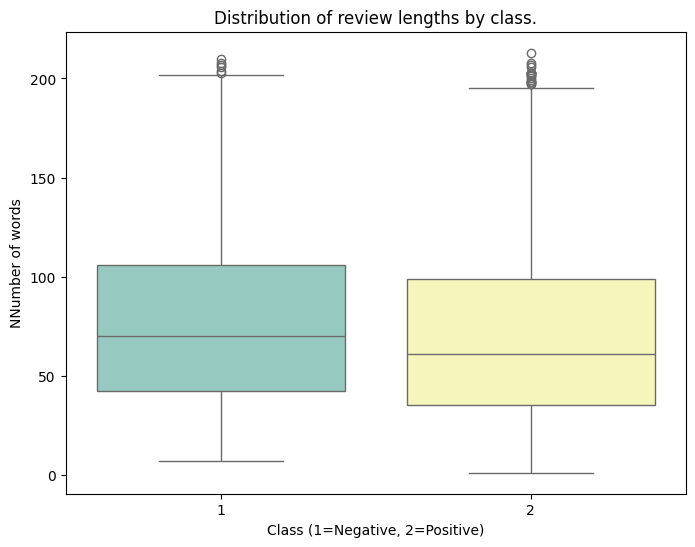

In [10]:
plt.figure(figsize=(8,6))
sns.boxplot(x="label", y="review_length", data=df, hue="label", palette="Set3", legend=False)
plt.title("Distribution of review lengths by class.")
plt.xlabel("Class (1=Negative, 2=Positive)")
plt.ylabel("NNumber of words")
plt.show()

### 3.6 Unique words per class (normalized frequency)

In [11]:
from collections import Counter

def get_normalized_freq(corpus):
    words = " ".join(corpus).lower().split()
    total = len(words)
    freq = Counter(words)
    return {w: c/total for w, c in freq.items()}

# Calculate relative frequency
pos_freq = get_normalized_freq(df[df["label"]==2]["content"])
neg_freq = get_normalized_freq(df[df["label"]==1]["content"])

# Difference in use between classes
diff_words = {}
for w in set(pos_freq.keys()).union(set(neg_freq.keys())):
    diff_words[w] = pos_freq.get(w,0) - neg_freq.get(w,0)

# Top exclusive positive words (more used in pos than in neg)
top_pos_exclusive = sorted(diff_words.items(), key=lambda x: x[1], reverse=True)[:20]

# Top exclusive negative words (more used in neg than in pos)
top_neg_exclusive = sorted(diff_words.items(), key=lambda x: x[1])[:20]

display(Markdown("🔹 Top exclusive words - Positive"))
display(pd.DataFrame(top_pos_exclusive, columns=["word", "diff_freq"]))

display(Markdown("🔹 Top exclusive words - Negative"))
display(pd.DataFrame(top_neg_exclusive, columns=["word", "diff_freq"]))

🔹 Top exclusive words - Positive

,word,diff_freq
0,and,0.005440
1,is,0.002987
2,great,0.002733
3,a,0.002359
4,of,0.001896
5,in,0.001463
6,love,0.001423
7,you,0.001205
8,for,0.001173
9,best,0.001083


🔹 Top exclusive words - Negative

,word,diff_freq
0,not,-0.004543
1,i,-0.003013
2,was,-0.003006
3,the,-0.002301
4,it,-0.001697
5,but,-0.001330
6,no,-0.001216
7,would,-0.001173
8,be,-0.000877
9,waste,-0.000869


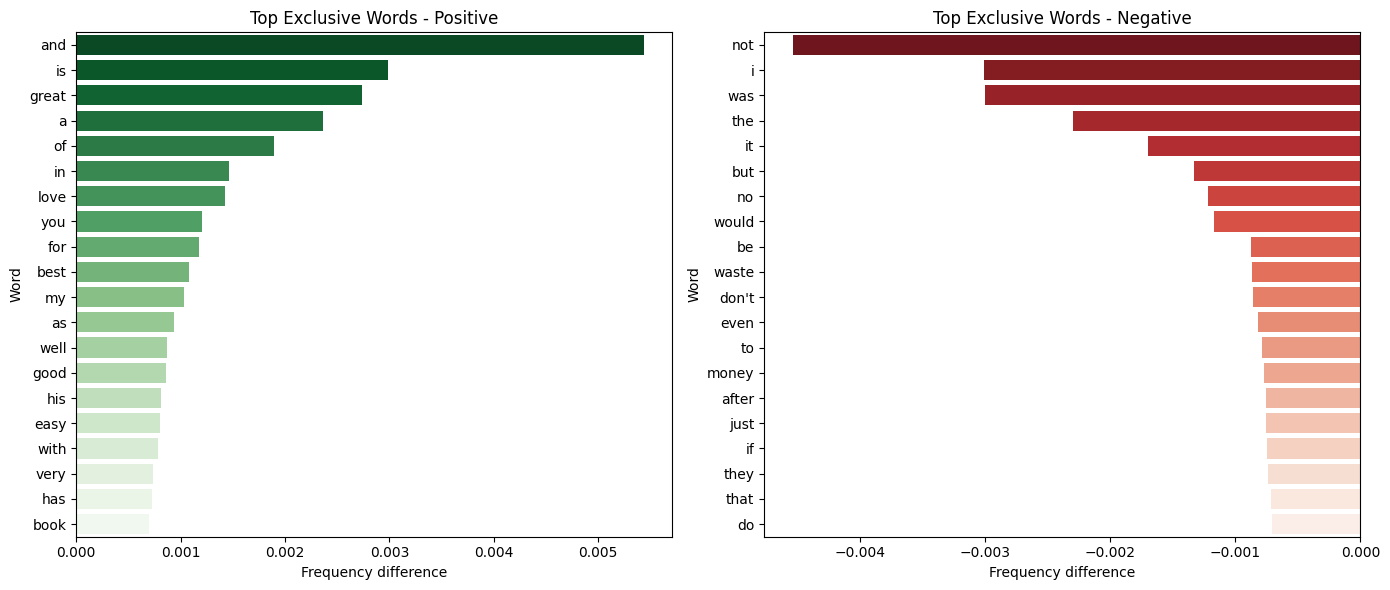

In [12]:
# We select the top 15 exclusives of each class
pos_exclusive = pd.DataFrame(top_pos_exclusive, columns=["word", "diff_freq"])
neg_exclusive = pd.DataFrame(top_neg_exclusive, columns=["word", "diff_freq"])

plt.figure(figsize=(14,6))

# Positives word plot
plt.subplot(1,2,1)
sns.barplot(y="word", x="diff_freq", data=pos_exclusive, hue = "word", palette="Greens_r")
plt.title("Top Exclusive Words - Positive")
plt.xlabel("Frequency difference")
plt.ylabel("Word")

# Negatives word plot
plt.subplot(1,2,2)
sns.barplot(y="word", x="diff_freq", data=neg_exclusive, hue = "word", palette="Reds_r")
plt.title("Top Exclusive Words - Negative")
plt.xlabel("Frequency difference")
plt.ylabel("Word")

plt.tight_layout()
plt.show()

### 3.7 Exploratory Data Analysis & Feature Engineering

📊 **EDA Summary**

1. **Class distribution**  
The dataset is well balanced between positive and negative reviews, which simplifies model training without the need for rebalancing techniques.

2. **Review length**  
Most reviews fall between 20 and 80 words. There are some outliers with very long texts, but overall, both classes show similar distributions. The median review length is around 65 words.

3. **Word Clouds & Exclusive Words**  
Common words like _book, movie, good_, and _like_ appear across both classes. Clear distinctions emerge: positive reviews emphasize _great, love, best, easy, well_, while negative reviews highlight _not, waste, money, don’t, bad_.

4. **N-grams**  
   - Positives: phrases such as _highly recommend, great book, easy read_ occur frequently.  
   - Negatives: expressions like _waste money, waste time, don’t buy, customer service_ are prominent, indicating common complaint patterns.

**Conclusion:**  
The exploratory data analysis reveals clear linguistic differences between positive and negative reviews, suggesting that textual features will be highly informative for sentiment classification.

For **feature engineering**, we transformed textual data into numerical features suitable for models: **TF-IDF vectorization** for traditional ML (Logistic Regression, SVM) and tokenization for **DistilBERT** with a maximum sequence length of 128 tokens based on the review length distribution. This ensures each model receives well-structured and meaningful input, setting the stage for **model training and evaluation**.

---

## 4. Feature engineering & Data preprocessing

Before training models, we need to carefully prepare the data to ensure consistency and maximize predictive performance. This section details the creation of features, the handling of labels, and the train/validation/test split.

### 4.1 Train/Val/Test split

In [13]:
from sklearn.model_selection import train_test_split

# Features & target
X = df["content"]
y = df["label"]

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Validation split from train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

display(Markdown(f"Train size: {len(X_train)}"))
display(Markdown(f"Validation size: {len(X_val)}"))
display(Markdown(f"Test size: {len(X_test)}"))

Train size: 96000

Validation size: 24000

Test size: 30001

### 4.2 Vectorization (TF-IDF)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    stop_words="english"
)

# Fit train and transform train/val/test
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)

display(Markdown("TF-IDF shapes:"))
display(Markdown(f"Train: {X_train_tfidf.shape}"))
display(Markdown(f"Val: {X_val_tfidf.shape}"))
display(Markdown(f"Test: {X_test_tfidf.shape}"))

TF-IDF shapes:

Train: (96000, 20000)

Val: (24000, 20000)

Test: (30001, 20000)

### 4.3 Baseline model

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Logistic Regression Validation Accuracy: 0.8672916666666667

,precision,recall,f1-score,support
Negative,0.873059,0.860208,0.866586,12025.000000
Positive,0.861669,0.874405,0.867990,11975.000000
accuracy,0.867292,0.867292,0.867292,0.867292
macro avg,0.867364,0.867306,0.867288,24000.000000
weighted avg,0.867376,0.867292,0.867286,24000.000000


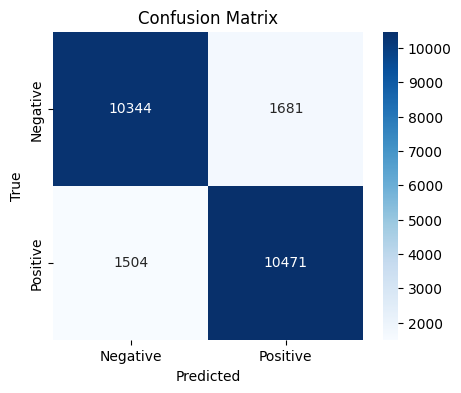

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, n_jobs=-1, verbose=1, random_state=42)

# Fit
log_reg.fit(X_train_tfidf, y_train)

# Validation
y_val_pred = log_reg.predict(X_val_tfidf)

# Model report
def evaluate_model(step ,y_true, y_pred, labels=None, show_cm=True):
    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    display(Markdown(f"{step} Accuracy: {acc}"))

    # DF Report
    report_dict = classification_report(y_true, y_pred, output_dict=True, target_names=labels)
    report_df = pd.DataFrame(report_dict).transpose()

    # Results
    display(report_df)

    # Confiusion Matrix
    if show_cm:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()

    return report_df, acc

df_report_val_lr, acc_val_lr = evaluate_model("Logistic Regression Validation", y_val, y_val_pred, labels=["Negative", "Positive"])

Logistic Regression Test Accuracy: 0.8654378187393753

,precision,recall,f1-score,support
Negative,0.867152,0.863748,0.865447,15031.000000
Positive,0.863730,0.867134,0.865429,14970.000000
accuracy,0.865438,0.865438,0.865438,0.865438
macro avg,0.865441,0.865441,0.865438,30001.000000
weighted avg,0.865445,0.865438,0.865438,30001.000000


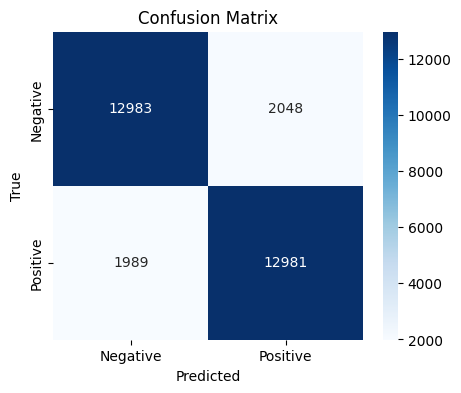

In [16]:
# Prediction on test set
y_test_pred = log_reg.predict(X_test_tfidf)
df_report_test_lr, acc_test_lr = evaluate_model("Logistic Regression Test", y_test, y_test_pred, labels=["Negative", "Positive"])

**Baseline Model Conclusion**  
The Logistic Regression model trained with TF-IDF features achieved strong and consistent performance. On the validation set, it reached an **accuracy of 86.7%**, and on the held-out test set, it obtained **86.5% accuracy**, showing only a minimal drop in performance (<0.2%).  
The model performs **balanced classification** between positive and negative reviews, with precision, recall, and F1-scores remaining very close across both classes. This indicates that the baseline model generalizes well and does not exhibit signs of overfitting.  
Overall, this baseline provides a *reliable benchmark* for sentiment classification, against which more advanced models (e.g., word embeddings or deep learning approaches) can be compared.

---

## 5. Modeling (Baselines vs. Advanced Models).
### 5.1 Support Vector Machine (SVM)

SVM Validation Accuracy: 0.863125

,precision,recall,f1-score,support
Negative,0.868155,0.856965,0.862524,12025.000000
Positive,0.858203,0.869311,0.863721,11975.000000
accuracy,0.863125,0.863125,0.863125,0.863125
macro avg,0.863179,0.863138,0.863122,24000.000000
weighted avg,0.863189,0.863125,0.863121,24000.000000


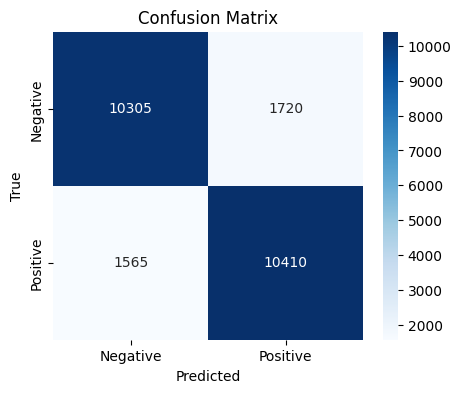

SVM Test Accuracy: 0.8605713142895237

,precision,recall,f1-score,support
Negative,0.862518,0.858559,0.860534,15031.000000
Positive,0.858634,0.862592,0.860608,14970.000000
accuracy,0.860571,0.860571,0.860571,0.860571
macro avg,0.860576,0.860575,0.860571,30001.000000
weighted avg,0.860580,0.860571,0.860571,30001.000000


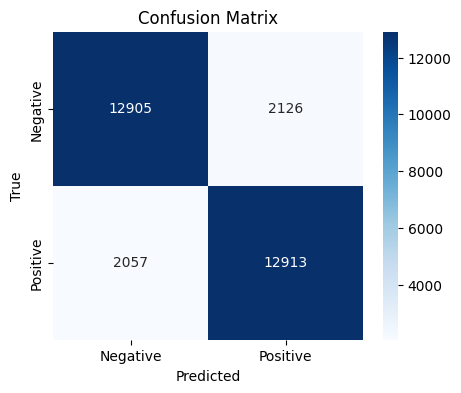

In [17]:
from sklearn.svm import LinearSVC

# Support Vector Machine
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train_tfidf, y_train)

# Validation
y_val_pred_svm = svm_model.predict(X_val_tfidf)

# Report validation
df_report_val_svm, acc_val_svm = evaluate_model("SVM Validation", y_val, y_val_pred_svm, labels=["Negative", "Positive"])

# Test
y_test_pred_svm = svm_model.predict(X_test_tfidf)

# Report test
df_report_test_svm, acc_test_svm = evaluate_model("SVM Test", y_test, y_test_pred_svm, labels=["Negative", "Positive"])



### 5.2 DistilBERT

In [18]:
from datasets import Dataset, ClassLabel
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.preprocessing import LabelEncoder
import torch

# Prepare dataset
df_model = df[["label", "title", "content"]].copy()

# Shuffle the dataframe
df_model = df_model.sample(frac=1, random_state=42).reset_index(drop=True)
df_model["label_enc"] = df_model["label"].map({1:0, 2:1})

# Train/Val/Test split
train_df, test_df = train_test_split(df_model, test_size=0.2, stratify=df_model["label_enc"], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df["label_enc"], random_state=42)

# 4. Convert to Hugging Face Dataset (text + label)
train_ds = Dataset.from_pandas(train_df[["content", "label_enc"]].rename(columns={"content":"text", "label_enc":"label"}))
val_ds = Dataset.from_pandas(val_df[["content", "label_enc"]].rename(columns={"content":"text", "label_enc":"label"}))
test_ds = Dataset.from_pandas(test_df[["content", "label_enc"]].rename(columns={"content":"text", "label_enc":"label"}))

display(train_ds)
display(val_ds)
display(test_ds)

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 96000
})

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 24000
})

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 30001
})

In [19]:
# Tokenizer
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [20]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"],padding="max_length", truncation=True, max_length=128)

In [21]:
# Tokenize datasets
train_ds = train_ds.map(tokenize_function, batched=True)
val_ds   = val_ds.map(tokenize_function, batched=True)
test_ds  = test_ds.map(tokenize_function, batched=True)

# Set format for PyTorch
train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/96000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30001 [00:00<?, ? examples/s]

In [22]:
from transformers import DistilBertForSequenceClassification

# Model DistilBERT
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.208900,0.202731,0.927958,0.920538,0.936451,0.928427
2,0.098600,0.244035,0.931667,0.944287,0.917161,0.930526
3,0.060100,0.313123,0.933292,0.928041,0.939123,0.933549


Validation DistilBERT Accuracy: 0.9332916666666666

,precision,recall,f1-score,support
Negative,0.938647,0.927484,0.933032,12025.000000
Positive,0.928041,0.939123,0.933549,11975.000000
accuracy,0.933292,0.933292,0.933292,0.933292
macro avg,0.933344,0.933304,0.933291,24000.000000
weighted avg,0.933355,0.933292,0.933290,24000.000000


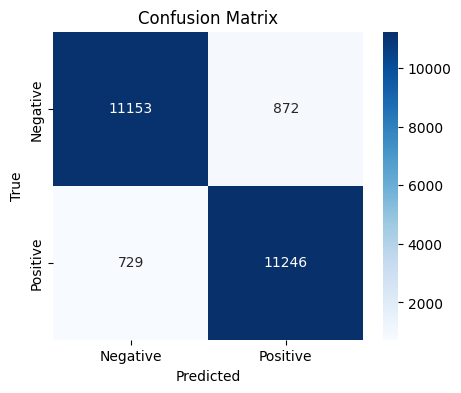

Test DistilBERT Accuracy: 0.9337022099263358

,precision,recall,f1-score,support
Negative,0.937651,0.929479,0.933547,15031.000000
Positive,0.929806,0.937943,0.933857,14970.000000
accuracy,0.933702,0.933702,0.933702,0.933702
macro avg,0.933728,0.933711,0.933702,30001.000000
weighted avg,0.933736,0.933702,0.933702,30001.000000


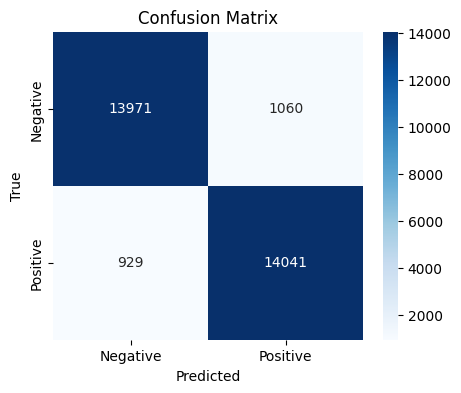

In [23]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Trainer
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=1,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_steps=50,
    metric_for_best_model="accuracy",
    greater_is_better=True,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

# Train
trainer.train()

# Validation
val_preds = trainer.predict(val_ds)
y_val_true = val_preds.label_ids
y_val_pred = val_preds.predictions.argmax(axis=-1)
df_report_val_bert, acc_val_bert = evaluate_model("Validation DistilBERT", y_val_true, y_val_pred, labels=["Negative", "Positive"])

# Test
test_preds = trainer.predict(test_ds)
y_test_true = test_preds.label_ids
y_test_pred = test_preds.predictions.argmax(axis=-1)
df_report_test_bert, acc_test_bert = evaluate_model("Test DistilBERT", y_test_true, y_test_pred, labels=["Negative", "Positive"])

## 6. Model Comparison & Conclusions

After performing feature engineering, preprocessing, and model training, we compared three different approaches for sentiment classification on the Amazon Reviews subset: Logistic Regression, SVM, and DistilBERT. 

### 6.1 Model Comparison Visualization

The following bar chart compares the three models in terms of **Test Accuracy** and **Training Time**.

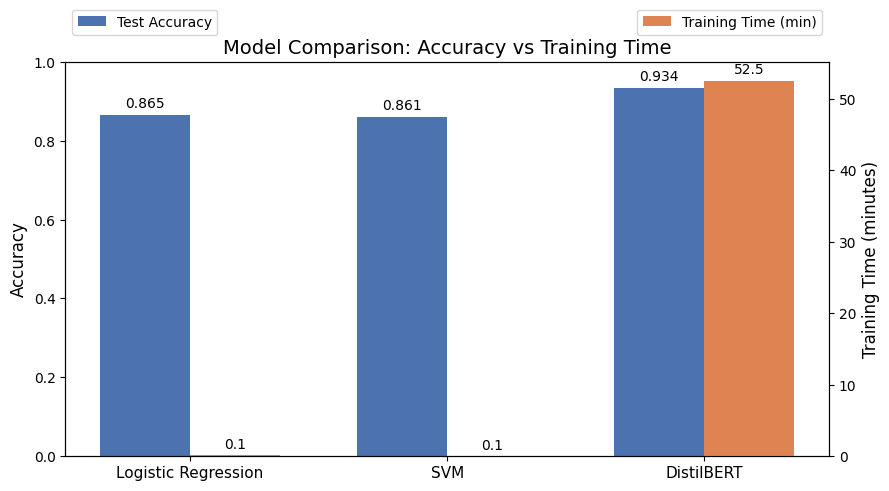

In [26]:
# Model names
models = ["Logistic Regression", "SVM", "DistilBERT"]

# Metrics
test_accuracy = [0.8654, 0.8606, 0.9340]             # Test Accuracy
train_time_min = [9/60, 3/60, 52 + 31.2/60]          # Training time in minutes

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(9,5))

# Accuracy bars
bars1 = ax1.bar(x - width/2, test_accuracy, width, label="Test Accuracy", color="#4c72b0")
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.set_ylim(0,1)
ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=11)
ax1.set_title("Model Comparison: Accuracy vs Training Time", fontsize=14)
ax1.legend(loc="upper left", bbox_to_anchor=(0, 1.15))  # Primera leyenda

# Training time bars on secondary axis
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, train_time_min, width, label="Training Time (min)", color="#dd8452")
ax2.set_ylabel("Training Time (minutes)", fontsize=12)
ax2.legend(loc="upper right", bbox_to_anchor=(1, 1.15))

# Annotate bars
for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{bar.get_height():.3f}", ha="center", va="bottom", fontsize=10)
    
for bar in bars2:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f"{bar.get_height():.1f}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

### 6.2 Table of Model Performance

| Model            | Train Time       | Validation Accuracy | Test Accuracy | Comments |
|-----------------|----------------|------------------|---------------|-------------|
| **Logistic Regression** | ~2.6 s           | 0.8673           | 0.8654        | Baseline classic model using TF-IDF. Fast and stable. |
| **SVM**          | ~1.8 s           | 0.8631           | 0.8606        | Lightweight and efficient. Performance similar to LR. |
| **DistilBERT**   | 52 m 31.2 s    | 0.9334           | 0.9340        | Fine-tuned transformer. Significant improvement, robust for NLP tasks. |

## 6.3 Key Conclusions

1. **Baseline models (LR & SVM)**:
   - Quick to train and suitable for smaller datasets.
   - Both achieved similar performance (around 86% accuracy) and provide a solid reference for evaluating more complex models.
   
2. **DistilBERT**:
   - Significantly outperformed the baseline models, achieving over 93% accuracy on both validation and test sets.
   - Shows the advantage of leveraging pre-trained language models for text classification.
   - Fine-tuning is computationally heavier (~53 minutes for this subset), but yields a more robust and generalizable model.

3. **Considerations for BERT-base**:
   - While potentially more powerful than DistilBERT, it requires more resources and may be prone to CUDA errors on local machines.
   - For portfolio purposes, DistilBERT is sufficient to demonstrate the application of transformer-based models.

4. **Overall Recommendation**:S
   - For quick experimentation and smaller datasets, baseline models like LR or SVM are effective.
   - For state-of-the-art performance in NLP tasks, transformer-based models like DistilBERT offer a clear advantage, even when fine-tuned on limited data.